# Centralized Baseline - Human Activity Recognition

This notebook implements the centralized baseline for UCI HAR dataset with **full reproducibility guarantees**.

**Experiment Configuration:**
- Dataset: UCI HAR (Human Activity Recognition)
- Training Mode: Centralized
- Seeds: [42, 123, 456]
- Total Runs: 3
- Epochs: 100

**Dataset Source:** https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones

**Compatible with:** Local environment and Kaggle

## 1. Environment Setup

In [1]:
# Check if running on Kaggle
import os

IS_KAGGLE = os.path.exists('/kaggle/input')

if IS_KAGGLE:
    print("Running on Kaggle")
    DATA_PATH = '/kaggle/input/human-activity-recognition-with-smartphones'
else:
    print("Running locally")
    # Update this path to where you downloaded the CSV files
    DATA_PATH = '.'

print(f"Data path: {DATA_PATH}")

Running on Kaggle
Data path: /kaggle/input/human-activity-recognition-with-smartphones


## 2. Import Libraries and Setup Reproducibility

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import random
import json
from datetime import datetime
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

PyTorch version: 2.6.0+cu124
NumPy version: 1.26.4
Pandas version: 2.2.3


In [3]:
def set_seed(seed):
    """
    Set all random seeds for reproducibility
    This ensures experiments can be reproduced exactly
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"All random seeds set to: {seed}")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")


Using device: cpu


## 3. Data Loading and Preprocessing

In [4]:
class UCIHARDataLoader:
    """
    Data loader for UCI HAR Dataset (CSV format from Kaggle)
    """
    def __init__(self, data_path='.'):
        self.data_path = data_path
        self.label_encoder = LabelEncoder()
        self.activity_labels = None
        
    def load_data(self):
        """
        Load train and test CSV files
        """
        # Load CSV files
        train_df = pd.read_csv(os.path.join(self.data_path, 'train.csv'))
        test_df = pd.read_csv(os.path.join(self.data_path, 'test.csv'))
        
        print(f"Train dataset shape: {train_df.shape}")
        print(f"Test dataset shape: {test_df.shape}")
        
        # Extract features and labels
        # Assuming 'Activity' column contains labels and 'subject' is the subject ID
        X_train = train_df.drop(['Activity', 'subject'], axis=1).values
        y_train = train_df['Activity'].values
        subjects_train = train_df['subject'].values
        
        X_test = test_df.drop(['Activity', 'subject'], axis=1).values
        y_test = test_df['Activity'].values
        subjects_test = test_df['subject'].values
        
        # Encode labels to numeric values
        self.label_encoder.fit(np.concatenate([y_train, y_test]))
        y_train_encoded = self.label_encoder.transform(y_train)
        y_test_encoded = self.label_encoder.transform(y_test)
        
        # Store activity labels
        self.activity_labels = {i: label for i, label in enumerate(self.label_encoder.classes_)}
        
        return X_train, y_train_encoded, subjects_train, X_test, y_test_encoded, subjects_test
    
    def get_dataloaders(self, batch_size=64, seed=42):
        """
        Get PyTorch DataLoaders for train and test sets
        """
        # Load data
        X_train, y_train, subjects_train, X_test, y_test, subjects_test = self.load_data()
        
        # Convert to PyTorch tensors
        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.LongTensor(y_train)
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.LongTensor(y_test)
        
        # Create datasets
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        
        # Create dataloaders
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True,
            worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id)
        )
        test_loader = DataLoader(
            test_dataset, 
            batch_size=batch_size, 
            shuffle=False
        )
        
        return train_loader, test_loader, X_train.shape[1], len(self.activity_labels)

# Load and inspect data
data_loader = UCIHARDataLoader(DATA_PATH)
X_train, y_train, subjects_train, X_test, y_test, subjects_test = data_loader.load_data()

print(f"\nActivity Labels:")
for idx, label in data_loader.activity_labels.items():
    print(f"  {idx}: {label}")

print(f"\nDataset Statistics:")
print(f"  Train samples: {X_train.shape[0]}")
print(f"  Test samples: {X_test.shape[0]}")
print(f"  Features: {X_train.shape[1]}")
print(f"  Classes: {len(np.unique(y_train))}")
print(f"  Train subjects: {len(np.unique(subjects_train))}")
print(f"  Test subjects: {len(np.unique(subjects_test))}")

Train dataset shape: (7352, 563)
Test dataset shape: (2947, 563)

Activity Labels:
  0: LAYING
  1: SITTING
  2: STANDING
  3: WALKING
  4: WALKING_DOWNSTAIRS
  5: WALKING_UPSTAIRS

Dataset Statistics:
  Train samples: 7352
  Test samples: 2947
  Features: 561
  Classes: 6
  Train subjects: 21
  Test subjects: 9


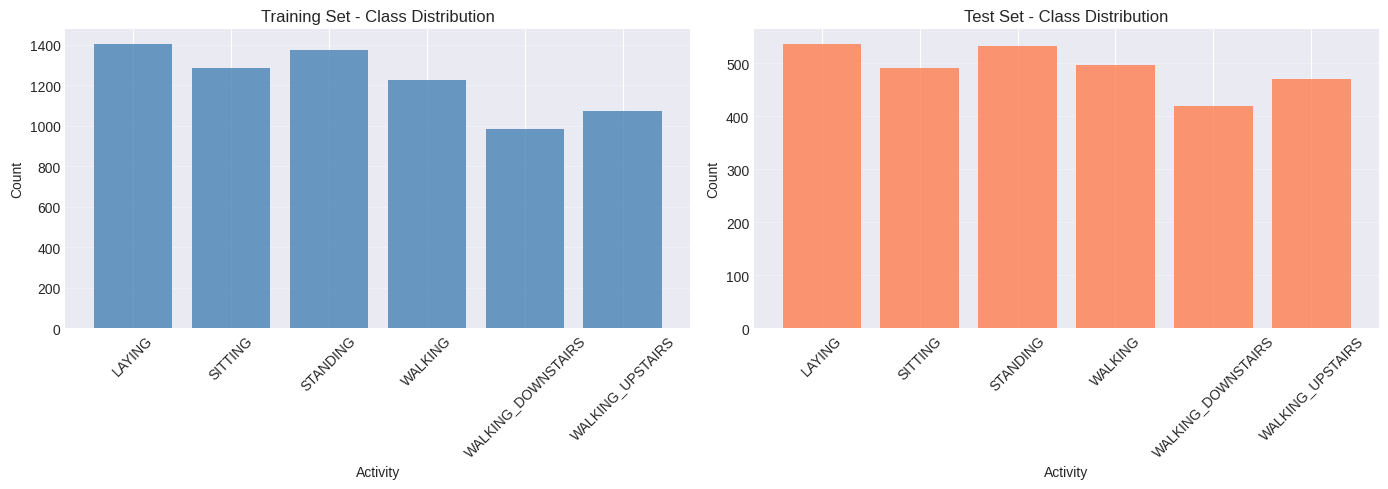

In [5]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set distribution
unique, counts = np.unique(y_train, return_counts=True)
axes[0].bar([data_loader.activity_labels[i] for i in unique], counts, alpha=0.8, color='steelblue')
axes[0].set_xlabel('Activity')
axes[0].set_ylabel('Count')
axes[0].set_title('Training Set - Class Distribution')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Test set distribution
unique, counts = np.unique(y_test, return_counts=True)
axes[1].bar([data_loader.activity_labels[i] for i in unique], counts, alpha=0.8, color='coral')
axes[1].set_xlabel('Activity')
axes[1].set_ylabel('Count')
axes[1].set_title('Test Set - Class Distribution')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 4. Model Architecture

In [6]:
class HARModel(nn.Module):
    """
    Multi-layer Perceptron for Human Activity Recognition
    Architecture: 561 -> 256 -> 128 -> 64 -> 6
    """
    def __init__(self, input_dim, num_classes, hidden_dims=[256, 128, 64], dropout=0.5):
        super(HARModel, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Hidden layers with BatchNorm and Dropout
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, num_classes))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Create model for summary
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = HARModel(input_dim, num_classes).to(device)

print("Model Architecture:")
print("="*60)
print(model)
print("="*60)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model Architecture:
HARModel(
  (model): Sequential(
    (0): Linear(in_features=561, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=64, out_features=6, bias=True)
  )
)
Total parameters: 186,310
Trainable parameters: 186,310


## 5. Training and Evaluation Functions

In [7]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train for one epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

def evaluate(model, test_loader, criterion, device):
    """
    Evaluate model on test set
    """
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = running_loss / len(all_labels)
    test_acc = accuracy_score(all_labels, all_preds)
    test_f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return test_loss, test_acc, test_f1, all_preds, all_labels

def train_model(model, train_loader, test_loader, criterion, optimizer, 
                num_epochs, device, verbose=True):
    """
    Complete training loop with validation
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'test_f1': []
    }
    
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Evaluate
        test_loss, test_acc, test_f1, _, _ = evaluate(model, test_loader, criterion, device)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['test_f1'].append(test_f1)
        
        if test_acc > best_acc:
            best_acc = test_acc
        
        if verbose and (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1:3d}/{num_epochs}] '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | '
                  f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}')
    
    return history, best_acc

## 6. Experiment Configuration

In [8]:
# Experiment configuration
EXPERIMENT_CONFIG = {
    'experiment_type': 'centralized',
    'dataset': 'UCI_HAR',
    'seeds': [42, 123, 456],
    'batch_size': 64,
    'num_epochs': 100,
    'learning_rate': 0.001,
    'optimizer': 'Adam',
    'hidden_dims': [256, 128, 64],
    'dropout': 0.5,
    'weight_decay': 1e-4
}

print("Experiment Configuration:")
print("="*60)
print(json.dumps(EXPERIMENT_CONFIG, indent=2))
print("="*60)

Experiment Configuration:
{
  "experiment_type": "centralized",
  "dataset": "UCI_HAR",
  "seeds": [
    42,
    123,
    456
  ],
  "batch_size": 64,
  "num_epochs": 100,
  "learning_rate": 0.001,
  "optimizer": "Adam",
  "hidden_dims": [
    256,
    128,
    64
  ],
  "dropout": 0.5,
  "weight_decay": 0.0001
}


## 7. Run Centralized Experiments (3 Seeds)

In [9]:
# Storage for results
all_results = []

# Run experiments with different seeds
for seed in EXPERIMENT_CONFIG['seeds']:
    print(f"\n{'='*80}")
    print(f" Running Centralized Baseline - Seed: {seed} ")
    print(f"{'='*80}\n")
    
    # Set seed for reproducibility
    set_seed(seed)
    
    # Load data
    data_loader = UCIHARDataLoader(DATA_PATH)
    train_loader, test_loader, input_dim, num_classes = data_loader.get_dataloaders(
        batch_size=EXPERIMENT_CONFIG['batch_size'],
        seed=seed
    )
    
    # Initialize model
    model = HARModel(
        input_dim=input_dim,
        num_classes=num_classes,
        hidden_dims=EXPERIMENT_CONFIG['hidden_dims'],
        dropout=EXPERIMENT_CONFIG['dropout']
    ).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=EXPERIMENT_CONFIG['learning_rate'],
        weight_decay=EXPERIMENT_CONFIG['weight_decay']
    )
    
    # Train model
    history, best_acc = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=EXPERIMENT_CONFIG['num_epochs'],
        device=device,
        verbose=True
    )
    
    # Final evaluation
    test_loss, test_acc, test_f1, predictions, true_labels = evaluate(
        model, test_loader, criterion, device
    )
    
    # Store results
    result = {
        'seed': seed,
        'test_accuracy': test_acc,
        'test_f1': test_f1,
        'test_loss': test_loss,
        'best_accuracy': best_acc,
        'history': history,
        'predictions': predictions,
        'true_labels': true_labels
    }
    all_results.append(result)
    
    print(f"\n{'-'*80}")
    print(f"Final Results - Seed {seed}:")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Test F1 Score: {test_f1:.4f}")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Best Accuracy: {best_acc:.4f}")
    print(f"{'-'*80}")

print(f"\n{'='*80}")
print(" ALL EXPERIMENTS COMPLETED SUCCESSFULLY ")
print(f"{'='*80}")


 Running Centralized Baseline - Seed: 42 

All random seeds set to: 42
Train dataset shape: (7352, 563)
Test dataset shape: (2947, 563)
Epoch [ 10/100] Train Loss: 0.1151, Train Acc: 0.9606 | Test Loss: 0.1385, Test Acc: 0.9508, Test F1: 0.9507
Epoch [ 20/100] Train Loss: 0.0848, Train Acc: 0.9705 | Test Loss: 0.2513, Test Acc: 0.9294, Test F1: 0.9295
Epoch [ 30/100] Train Loss: 0.0690, Train Acc: 0.9780 | Test Loss: 0.1390, Test Acc: 0.9589, Test F1: 0.9588
Epoch [ 40/100] Train Loss: 0.0610, Train Acc: 0.9807 | Test Loss: 0.1229, Test Acc: 0.9637, Test F1: 0.9636
Epoch [ 50/100] Train Loss: 0.0548, Train Acc: 0.9826 | Test Loss: 0.1815, Test Acc: 0.9525, Test F1: 0.9525
Epoch [ 60/100] Train Loss: 0.0519, Train Acc: 0.9837 | Test Loss: 0.1926, Test Acc: 0.9518, Test F1: 0.9513
Epoch [ 70/100] Train Loss: 0.0491, Train Acc: 0.9845 | Test Loss: 0.1584, Test Acc: 0.9562, Test F1: 0.9560
Epoch [ 80/100] Train Loss: 0.0489, Train Acc: 0.9850 | Test Loss: 0.1405, Test Acc: 0.9572, Test F1

## 8. Results Summary Statistics

In [10]:
# Extract metrics
accuracies = [r['test_accuracy'] for r in all_results]
f1_scores = [r['test_f1'] for r in all_results]
losses = [r['test_loss'] for r in all_results]

print("\n" + "="*80)
print(" CENTRALIZED BASELINE SUMMARY ")
print("="*80)
print(f"\nNumber of runs: {len(all_results)}")
print(f"Seeds: {EXPERIMENT_CONFIG['seeds']}")

print(f"\nTest Accuracy:")
print(f"  Mean: {np.mean(accuracies):.4f} +/- {np.std(accuracies):.4f}")
print(f"  Median: {np.median(accuracies):.4f}")
print(f"  Min: {np.min(accuracies):.4f}")
print(f"  Max: {np.max(accuracies):.4f}")

print(f"\nTest F1 Score (Weighted):")
print(f"  Mean: {np.mean(f1_scores):.4f} +/- {np.std(f1_scores):.4f}")
print(f"  Median: {np.median(f1_scores):.4f}")
print(f"  Min: {np.min(f1_scores):.4f}")
print(f"  Max: {np.max(f1_scores):.4f}")

print(f"\nTest Loss:")
print(f"  Mean: {np.mean(losses):.4f} +/- {np.std(losses):.4f}")
print(f"  Median: {np.median(losses):.4f}")
print(f"  Min: {np.min(losses):.4f}")
print(f"  Max: {np.max(losses):.4f}")

print("="*80)

# Create detailed results table
results_df = pd.DataFrame([{
    'Seed': r['seed'],
    'Test Accuracy': f"{r['test_accuracy']:.4f}",
    'Test F1': f"{r['test_f1']:.4f}",
    'Test Loss': f"{r['test_loss']:.4f}",
    'Best Accuracy': f"{r['best_accuracy']:.4f}"
} for r in all_results])

print("\nDetailed Results per Seed:")
print(results_df.to_string(index=False))


 CENTRALIZED BASELINE SUMMARY 

Number of runs: 3
Seeds: [42, 123, 456]

Test Accuracy:
  Mean: 0.9240 +/- 0.0155
  Median: 0.9155
  Min: 0.9108
  Max: 0.9457

Test F1 Score (Weighted):
  Mean: 0.9208 +/- 0.0172
  Median: 0.9108
  Min: 0.9067
  Max: 0.9450

Test Loss:
  Mean: 0.3253 +/- 0.0518
  Median: 0.3326
  Min: 0.2586
  Max: 0.3848

Detailed Results per Seed:
 Seed Test Accuracy Test F1 Test Loss Best Accuracy
   42        0.9155  0.9108    0.3326        0.9678
  123        0.9108  0.9067    0.3848        0.9684
  456        0.9457  0.9450    0.2586        0.9701


## 9. Comprehensive Visualizations

### 9.1 Training Curves - Loss and Accuracy

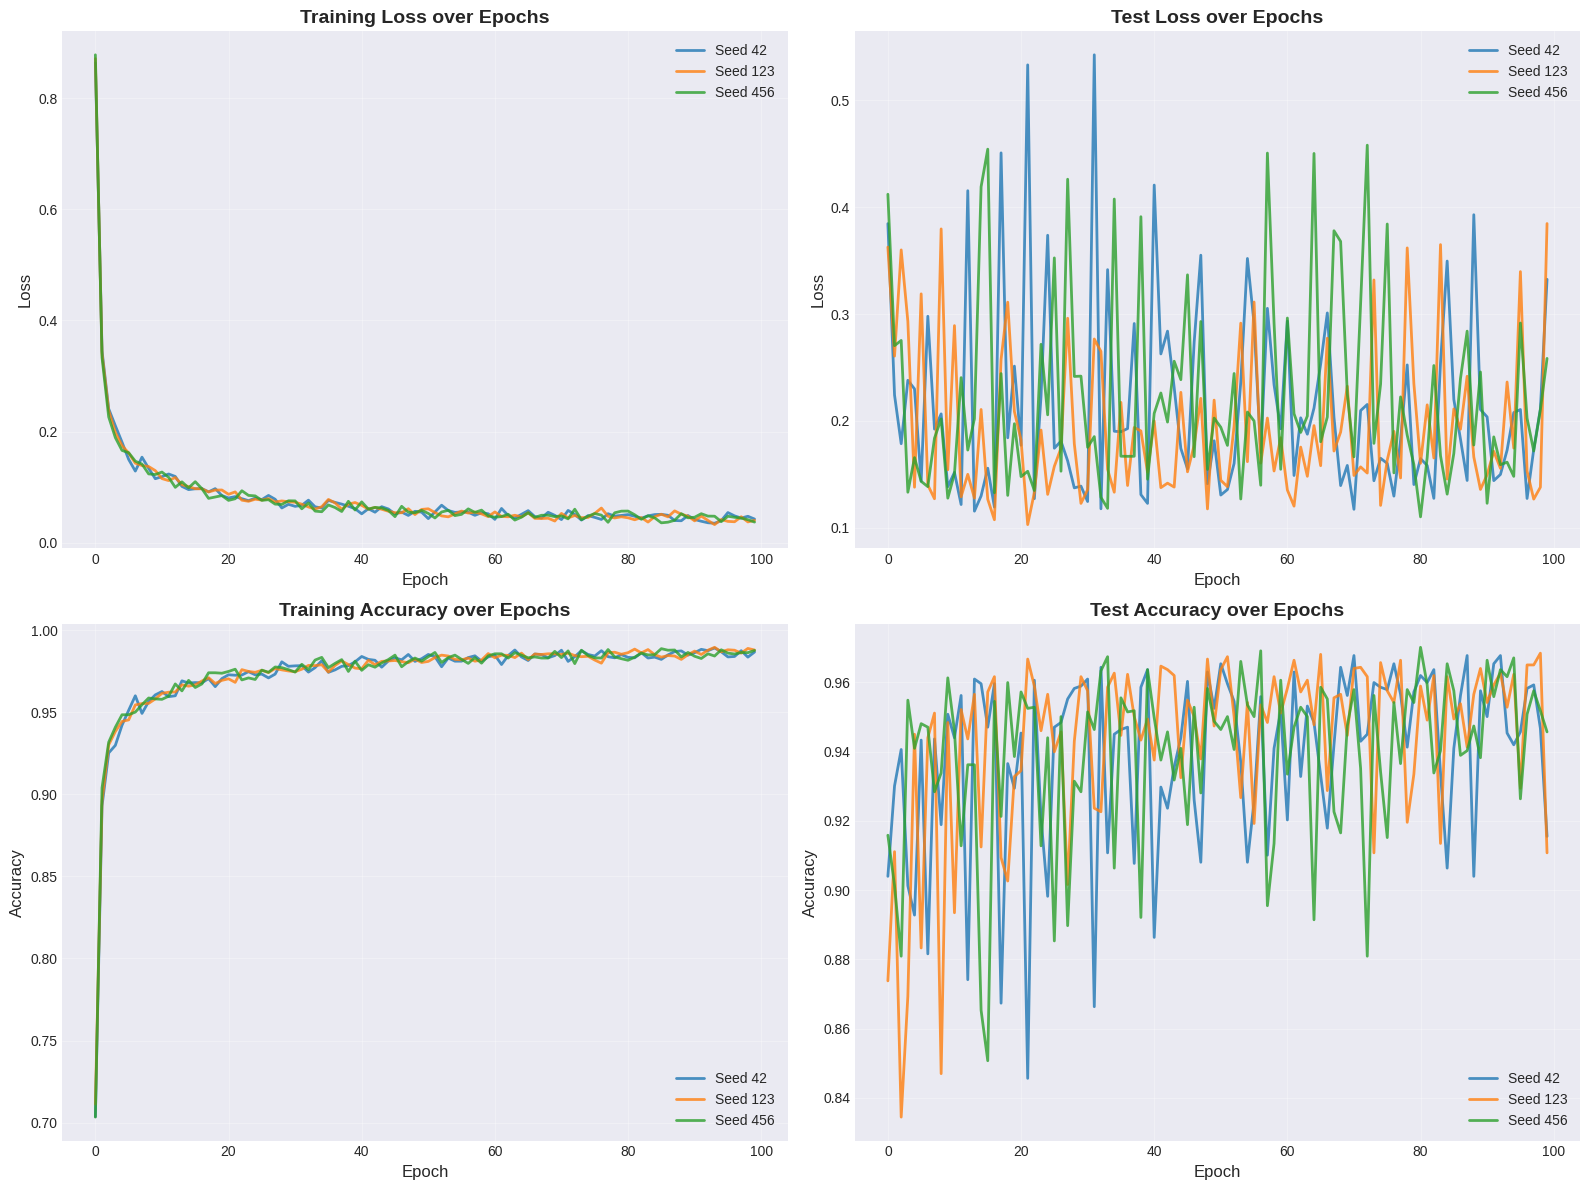

In [11]:
# Combined training curves for all seeds
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, result in enumerate(all_results):
    seed = result['seed']
    history = result['history']
    color = colors[i]
    
    # Plot training loss
    axes[0, 0].plot(history['train_loss'], label=f'Seed {seed}', alpha=0.8, color=color, linewidth=2)
    
    # Plot test loss
    axes[0, 1].plot(history['test_loss'], label=f'Seed {seed}', alpha=0.8, color=color, linewidth=2)
    
    # Plot training accuracy
    axes[1, 0].plot(history['train_acc'], label=f'Seed {seed}', alpha=0.8, color=color, linewidth=2)
    
    # Plot test accuracy
    axes[1, 1].plot(history['test_acc'], label=f'Seed {seed}', alpha=0.8, color=color, linewidth=2)

# Training Loss
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training Loss over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Test Loss
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].set_title('Test Loss over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Training Accuracy
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Accuracy', fontsize=12)
axes[1, 0].set_title('Training Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Test Accuracy
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Accuracy', fontsize=12)
axes[1, 1].set_title('Test Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves_all_seeds.png', dpi=300, bbox_inches='tight')
plt.show()

### 9.2 F1 Score and Combined Loss/Accuracy

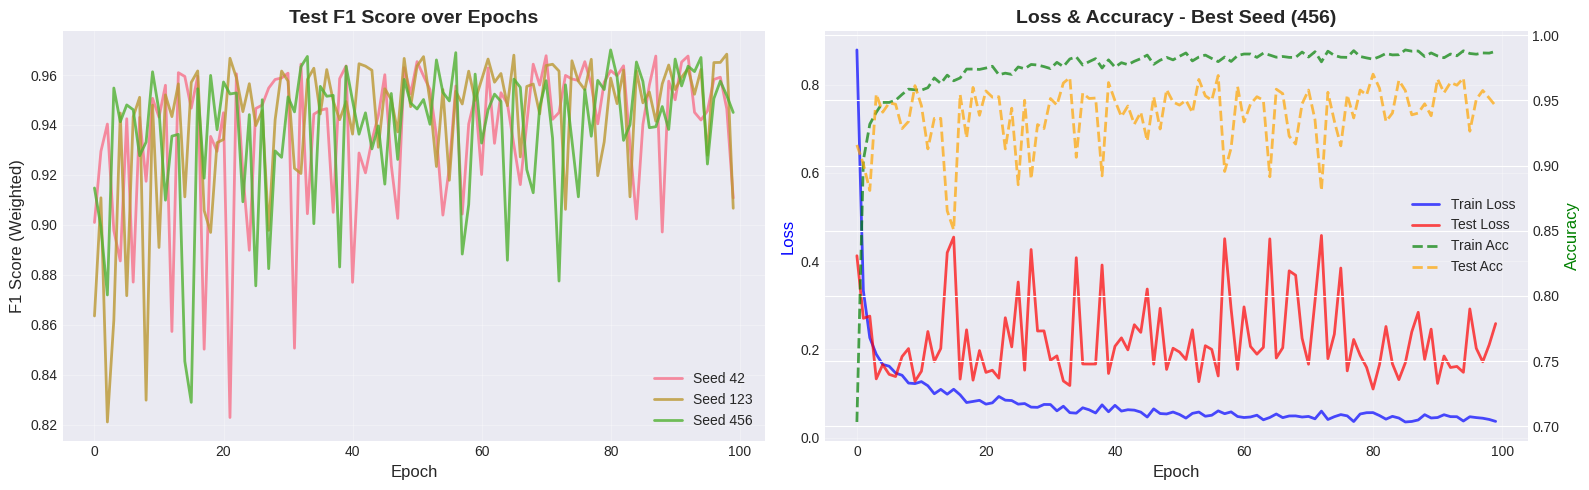

In [12]:
# F1 Score and combined metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# F1 Score over epochs
for i, result in enumerate(all_results):
    seed = result['seed']
    history = result['history']
    axes[0].plot(history['test_f1'], label=f'Seed {seed}', alpha=0.8, linewidth=2)

axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('F1 Score (Weighted)', fontsize=12)
axes[0].set_title('Test F1 Score over Epochs', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Combined Train/Test for best seed
best_result = max(all_results, key=lambda x: x['test_accuracy'])
history = best_result['history']

ax1 = axes[1]
ax2 = ax1.twinx()

ln1 = ax1.plot(history['train_loss'], label='Train Loss', color='blue', alpha=0.7, linewidth=2)
ln2 = ax1.plot(history['test_loss'], label='Test Loss', color='red', alpha=0.7, linewidth=2)
ln3 = ax2.plot(history['train_acc'], label='Train Acc', color='green', alpha=0.7, linewidth=2, linestyle='--')
ln4 = ax2.plot(history['test_acc'], label='Test Acc', color='orange', alpha=0.7, linewidth=2, linestyle='--')

ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12, color='blue')
ax2.set_ylabel('Accuracy', fontsize=12, color='green')
ax1.set_title(f'Loss & Accuracy - Best Seed ({best_result["seed"]})', fontsize=14, fontweight='bold')

# Combine legends
lns = ln1 + ln2 + ln3 + ln4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right', fontsize=10)
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('f1_and_combined_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

### 9.3 Performance Comparison Across Seeds

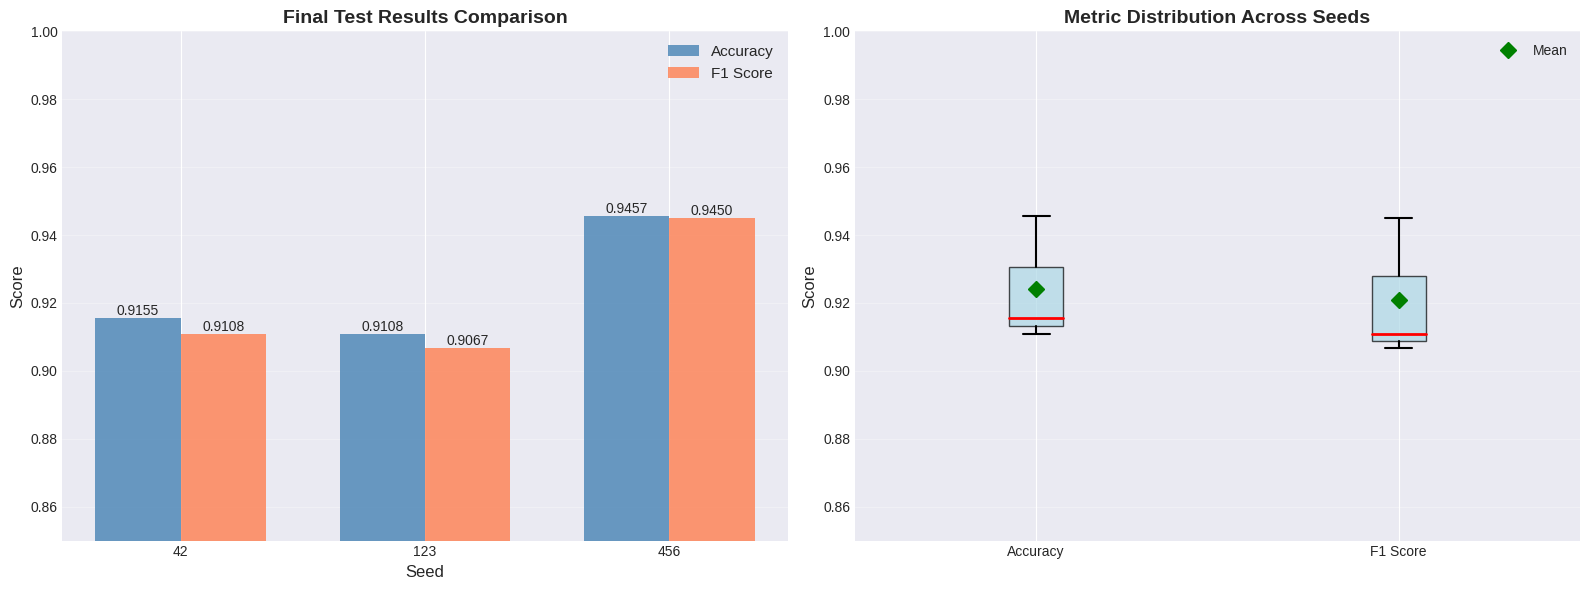

In [13]:
# Performance comparison across seeds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot comparison
seeds = [r['seed'] for r in all_results]
accs = [r['test_accuracy'] for r in all_results]
f1s = [r['test_f1'] for r in all_results]

x = np.arange(len(seeds))
width = 0.35

bars1 = axes[0].bar(x - width/2, accs, width, label='Accuracy', alpha=0.8, color='steelblue')
bars2 = axes[0].bar(x + width/2, f1s, width, label='F1 Score', alpha=0.8, color='coral')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10)

axes[0].set_xlabel('Seed', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Final Test Results Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(seeds)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0.85, 1.0])

# Box plot for metric distribution
metric_data = [accs, f1s]
bp = axes[1].boxplot(metric_data, labels=['Accuracy', 'F1 Score'], patch_artist=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(linewidth=1.5),
                     capprops=dict(linewidth=1.5))

axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Metric Distribution Across Seeds', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0.85, 1.0])

# Add mean markers
means = [np.mean(accs), np.mean(f1s)]
axes[1].plot([1, 2], means, 'D', color='green', markersize=8, label='Mean', zorder=3)
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 9.4 Confusion Matrices for All Seeds

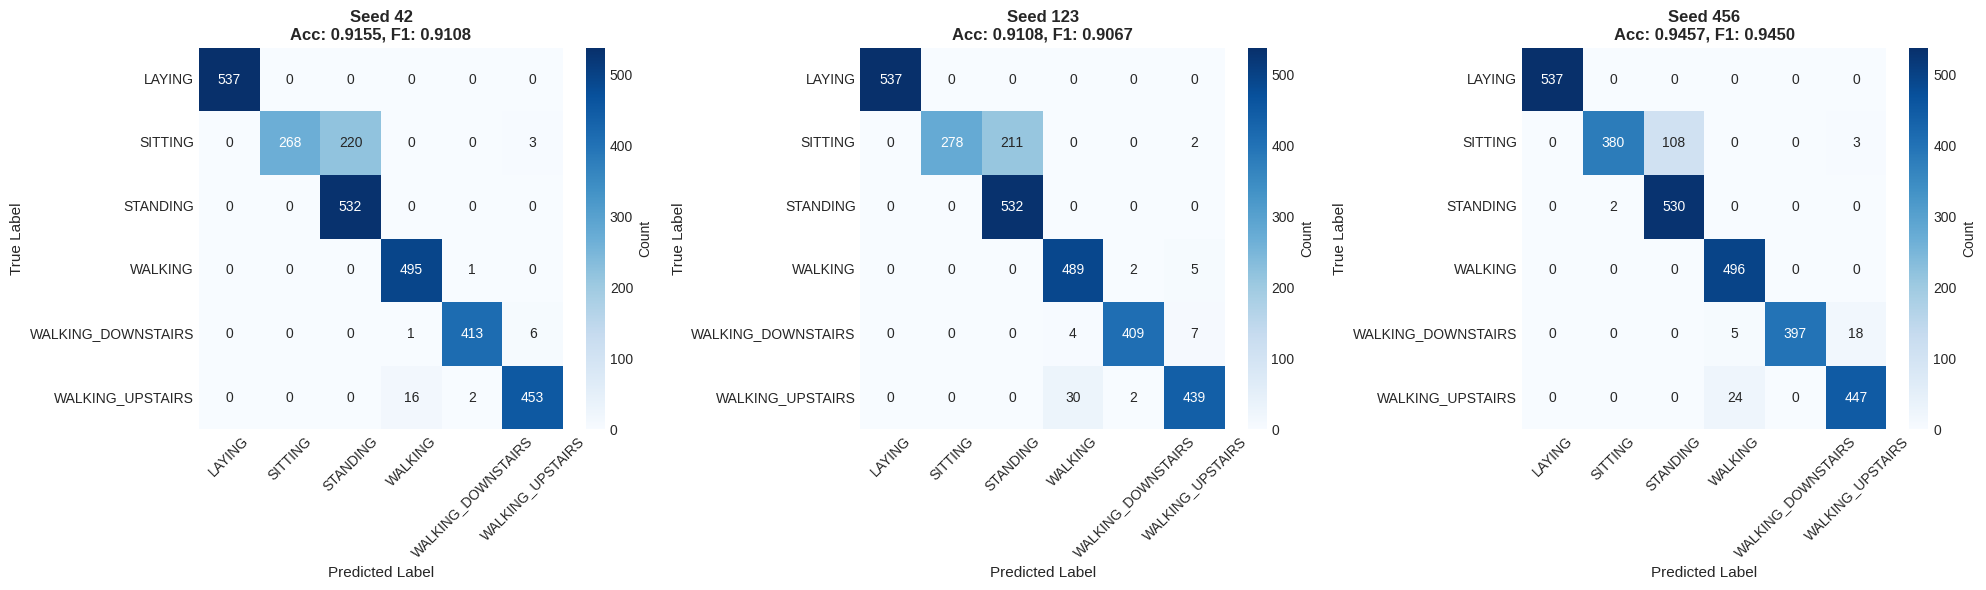

In [14]:
# Confusion matrices for all seeds
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, result in enumerate(all_results):
    cm = confusion_matrix(result['true_labels'], result['predictions'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=data_loader.activity_labels.values(),
                yticklabels=data_loader.activity_labels.values(),
                cbar_kws={'label': 'Count'})
    
    axes[i].set_title(f'Seed {result["seed"]}\nAcc: {result["test_accuracy"]:.4f}, F1: {result["test_f1"]:.4f}',
                     fontsize=12, fontweight='bold')
    axes[i].set_ylabel('True Label', fontsize=11)
    axes[i].set_xlabel('Predicted Label', fontsize=11)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('confusion_matrices_all_seeds.png', dpi=300, bbox_inches='tight')
plt.show()

### 9.5 Normalized Confusion Matrix (Best Seed)

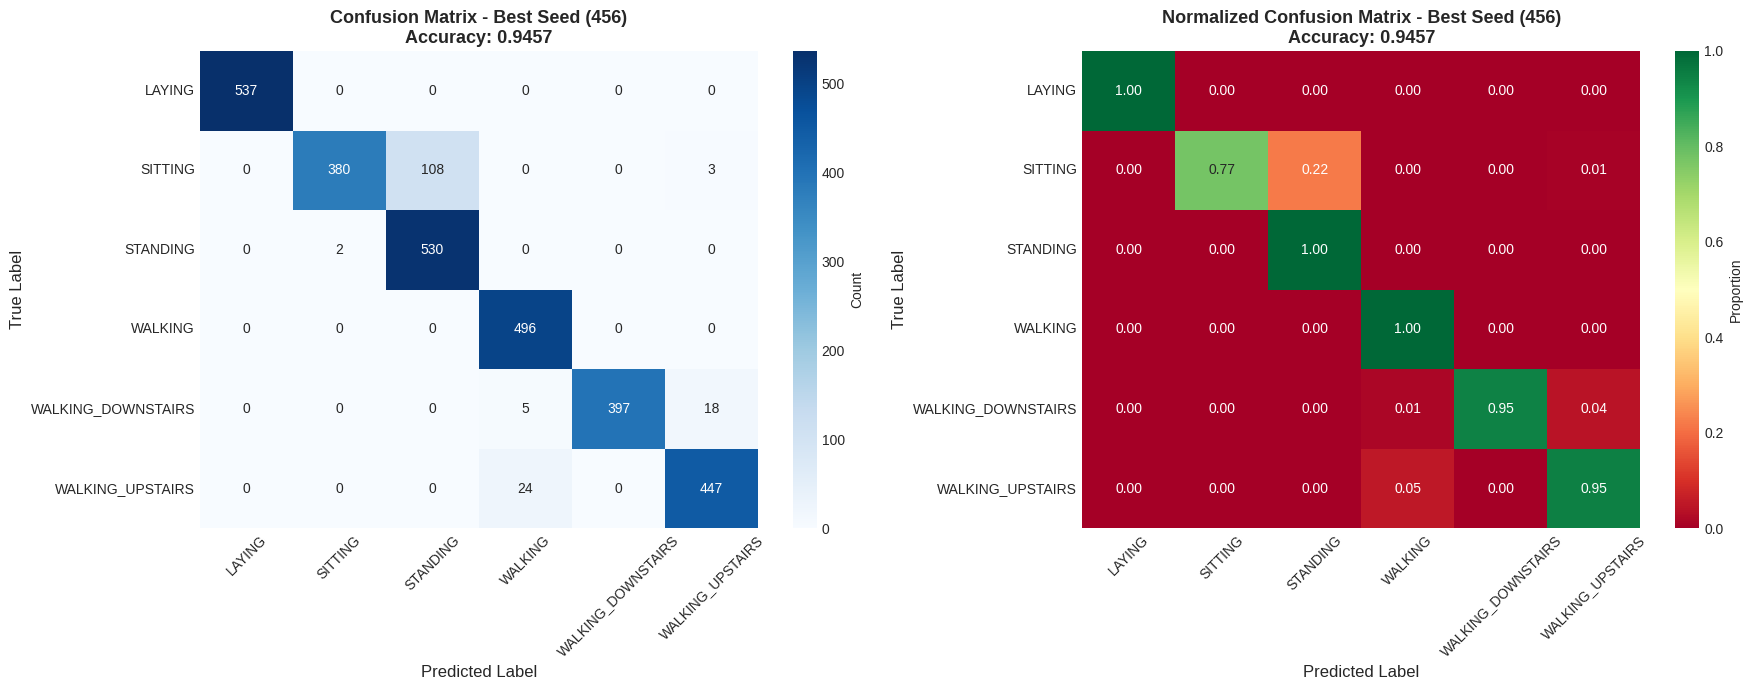

In [15]:
# Normalized confusion matrix for best seed
best_result = max(all_results, key=lambda x: x['test_accuracy'])
cm = confusion_matrix(best_result['true_labels'], best_result['predictions'])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=data_loader.activity_labels.values(),
            yticklabels=data_loader.activity_labels.values(),
            cbar_kws={'label': 'Count'})
axes[0].set_title(f'Confusion Matrix - Best Seed ({best_result["seed"]})\nAccuracy: {best_result["test_accuracy"]:.4f}',
                 fontsize=13, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn', ax=axes[1],
            xticklabels=data_loader.activity_labels.values(),
            yticklabels=data_loader.activity_labels.values(),
            cbar_kws={'label': 'Proportion'}, vmin=0, vmax=1)
axes[1].set_title(f'Normalized Confusion Matrix - Best Seed ({best_result["seed"]})\nAccuracy: {best_result["test_accuracy"]:.4f}',
                 fontsize=13, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('confusion_matrix_best_seed.png', dpi=300, bbox_inches='tight')
plt.show()

### 9.6 Per-Class Performance Analysis


Per-Class Performance (Best Seed: 456):
          Activity  Precision   Recall  F1-Score  Support
            LAYING   1.000000 1.000000  1.000000      537
           SITTING   0.994764 0.773931  0.870561      491
          STANDING   0.830721 0.996241  0.905983      532
           WALKING   0.944762 1.000000  0.971596      496
WALKING_DOWNSTAIRS   1.000000 0.945238  0.971848      420
  WALKING_UPSTAIRS   0.955128 0.949045  0.952077      471


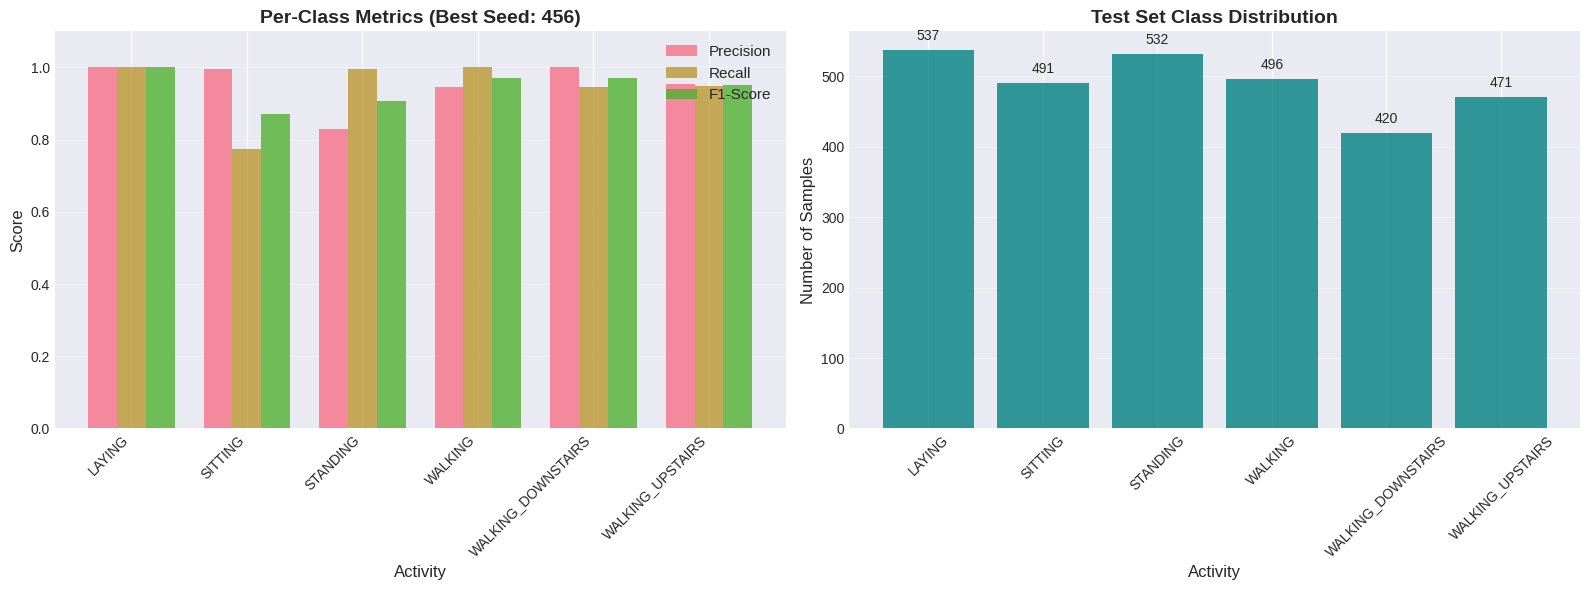

In [16]:
# Per-class performance for best seed
best_result = max(all_results, key=lambda x: x['test_accuracy'])

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    best_result['true_labels'], 
    best_result['predictions']
)

# Create dataframe
class_metrics = pd.DataFrame({
    'Activity': list(data_loader.activity_labels.values()),
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print(f"\nPer-Class Performance (Best Seed: {best_result['seed']}):")
print("="*80)
print(class_metrics.to_string(index=False))
print("="*80)

# Visualize per-class metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot for precision, recall, F1
x = np.arange(len(class_metrics))
width = 0.25

axes[0].bar(x - width, class_metrics['Precision'], width, label='Precision', alpha=0.8)
axes[0].bar(x, class_metrics['Recall'], width, label='Recall', alpha=0.8)
axes[0].bar(x + width, class_metrics['F1-Score'], width, label='F1-Score', alpha=0.8)

axes[0].set_xlabel('Activity', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title(f'Per-Class Metrics (Best Seed: {best_result["seed"]})', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(class_metrics['Activity'], rotation=45, ha='right')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.1])

# Support bar plot
axes[1].bar(class_metrics['Activity'], class_metrics['Support'], alpha=0.8, color='teal')
axes[1].set_xlabel('Activity', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(class_metrics['Support']):
    axes[1].text(i, v + 10, str(int(v)), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('per_class_performance.png', dpi=300, bbox_inches='tight')
plt.show()

### 9.7 Classification Report (All Seeds)

In [17]:
# Classification reports for all seeds
for result in all_results:
    print(f"\n{'='*80}")
    print(f" Classification Report - Seed {result['seed']} ")
    print(f" Test Accuracy: {result['test_accuracy']:.4f} | F1: {result['test_f1']:.4f} ")
    print(f"{'='*80}")
    print(classification_report(
        result['true_labels'], 
        result['predictions'],
        target_names=list(data_loader.activity_labels.values()),
        digits=4
    ))


 Classification Report - Seed 42 
 Test Accuracy: 0.9155 | F1: 0.9108 
                    precision    recall  f1-score   support

            LAYING     1.0000    1.0000    1.0000       537
           SITTING     1.0000    0.5458    0.7062       491
          STANDING     0.7074    1.0000    0.8287       532
           WALKING     0.9668    0.9980    0.9821       496
WALKING_DOWNSTAIRS     0.9928    0.9833    0.9880       420
  WALKING_UPSTAIRS     0.9805    0.9618    0.9711       471

          accuracy                         0.9155      2947
         macro avg     0.9413    0.9148    0.9127      2947
      weighted avg     0.9375    0.9155    0.9108      2947


 Classification Report - Seed 123 
 Test Accuracy: 0.9108 | F1: 0.9067 
                    precision    recall  f1-score   support

            LAYING     1.0000    1.0000    1.0000       537
           SITTING     1.0000    0.5662    0.7230       491
          STANDING     0.7160    1.0000    0.8345       532
           

## 10. Save Results

In [18]:
# Create results directory
os.makedirs('results/centralized', exist_ok=True)

# Save experiment configuration and results
output = {
    'experiment_config': EXPERIMENT_CONFIG,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'device': str(device),
    'pytorch_version': torch.__version__,
    'is_kaggle': IS_KAGGLE,
    'summary': {
        'mean_accuracy': float(np.mean(accuracies)),
        'std_accuracy': float(np.std(accuracies)),
        'median_accuracy': float(np.median(accuracies)),
        'mean_f1': float(np.mean(f1_scores)),
        'std_f1': float(np.std(f1_scores)),
        'median_f1': float(np.median(f1_scores)),
        'min_accuracy': float(np.min(accuracies)),
        'max_accuracy': float(np.max(accuracies)),
        'best_seed': int(max(all_results, key=lambda x: x['test_accuracy'])['seed'])
    },
    'runs': [
        {
            'seed': r['seed'],
            'test_accuracy': float(r['test_accuracy']),
            'test_f1': float(r['test_f1']),
            'test_loss': float(r['test_loss']),
            'best_accuracy': float(r['best_accuracy'])
        }
        for r in all_results
    ]
}

# Save JSON
with open('results/centralized/centralized_baseline_results.json', 'w') as f:
    json.dump(output, f, indent=2)

# Save detailed results as CSV
results_df.to_csv('results/centralized/centralized_baseline_summary.csv', index=False)

# Save per-class metrics
if 'class_metrics' in locals():
    class_metrics.to_csv('results/centralized/per_class_metrics.csv', index=False)

print("\nResults saved successfully:")
print("="*60)
print("  - results/centralized/centralized_baseline_results.json")
print("  - results/centralized/centralized_baseline_summary.csv")
print("  - results/centralized/per_class_metrics.csv")
print("\nVisualizations saved:")
print("  - training_curves_all_seeds.png")
print("  - f1_and_combined_metrics.png")
print("  - performance_comparison.png")
print("  - confusion_matrices_all_seeds.png")
print("  - confusion_matrix_best_seed.png")
print("  - per_class_performance.png")
print("="*60)


Results saved successfully:
  - results/centralized/centralized_baseline_results.json
  - results/centralized/centralized_baseline_summary.csv
  - results/centralized/per_class_metrics.csv

Visualizations saved:
  - training_curves_all_seeds.png
  - f1_and_combined_metrics.png
  - performance_comparison.png
  - confusion_matrices_all_seeds.png
  - confusion_matrix_best_seed.png
  - per_class_performance.png
